# Import Libraries

In [ ]:
!pip install -q -U keras-tuner
import keras_tuner as kt
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 4.3 MB/s eta 0:00:00


# Load Images

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive/Tugas Akhir/Dataset'

/content/drive/MyDrive/Tugas Akhir/Dataset


In [ ]:
directories = os.listdir()
directories.sort()
filename = []
label = []

for i in range(0, len(directories)):
  os.chdir(directories[i])
  files = os.listdir()
  files.sort()
  for j in range(0, len(files)):
    files[j] = directories[i] + '/' + files[j]
    label.append(directories[i])
  filename = filename + files
  os.chdir("..")

print(filename)
print(label)

['Blue Green Algae/Anabaena (1)_1.jpg', 'Blue Green Algae/Anabaena (1)_10.jpg', 'Blue Green Algae/Anabaena (1)_100.jpg', 'Blue Green Algae/Anabaena (1)_101.jpg', 'Blue Green Algae/Anabaena (1)_102.jpg', 'Blue Green Algae/Anabaena (1)_103.jpg', 'Blue Green Algae/Anabaena (1)_104.jpg', 'Blue Green Algae/Anabaena (1)_105.jpg', 'Blue Green Algae/Anabaena (1)_106.jpg', 'Blue Green Algae/Anabaena (1)_107.jpg', 'Blue Green Algae/Anabaena (1)_108.jpg', 'Blue Green Algae/Anabaena (1)_11.jpg', 'Blue Green Algae/Anabaena (1)_12.jpg', 'Blue Green Algae/Anabaena (1)_13.jpg', 'Blue Green Algae/Anabaena (1)_14.jpg', 'Blue Green Algae/Anabaena (1)_15.jpg', 'Blue Green Algae/Anabaena (1)_16.jpg', 'Blue Green Algae/Anabaena (1)_17.jpg', 'Blue Green Algae/Anabaena (1)_18.jpg', 'Blue Green Algae/Anabaena (1)_19.jpg', 'Blue Green Algae/Anabaena (1)_2.jpg', 'Blue Green Algae/Anabaena (1)_20.jpg', 'Blue Green Algae/Anabaena (1)_21.jpg', 'Blue Green Algae/Anabaena (1)_22.jpg', 'Blue Green Algae/Anabaena (1)_2

In [ ]:
data = {"filename": filename, "label": label}
df = pd.DataFrame(data = data)
dataset = df.sample(frac = 1)
print(dataset)

                                       filename             label
2490       Blue Green Algae/Anabaena (7)_22.jpg  Blue Green Algae
7207                 Diatom/Navicula (2)_83.jpg            Diatom
15829       Green Algae/Scenedesmus (49)_32.jpg       Green Algae
7312                  Diatom/Navicula (7)_2.jpg            Diatom
11629     Green Algae/Chlamydomonas (98)_94.jpg       Green Algae
...                                         ...               ...
265       Blue Green Algae/Anabaena (12)_19.jpg  Blue Green Algae
17036        Green Algae/Tetraselmis (39)_5.jpg       Green Algae
4717   Blue Green Algae/Microcystis (21)_15.jpg  Blue Green Algae
3779    Blue Green Algae/Chroococcus (22)_7.jpg  Blue Green Algae
10995     Green Algae/Chlamydomonas (75)_38.jpg       Green Algae

[17276 rows x 2 columns]


In [ ]:
def load_images_files(train_data):
  images = []
  y = []
  for obj in tqdm(train_data.values, desc = 'Load Images Progress Bar'):
    img = tf.keras.preprocessing.image.load_img(obj[0], target_size=(75, 75, 3))
    img = tf.keras.preprocessing.image.img_to_array(img)
    images.append(img)
    y.append(obj[1])
  X = np.array(images)
  y = np.array(y)

  return X, y

In [ ]:
X, y = load_images_files(dataset) 

Load Images Progress Bar: 100%|██████████| 17276/17276 [1:18:18<00:00,  3.68it/s]


In [ ]:
np.save('/content/drive/MyDrive/Tugas Akhir/np75/X_alga.npy', X)
np.save('/content/drive/MyDrive/Tugas Akhir/np75/y_alga.npy', y)

In [ ]:
X = np.load('/content/drive/MyDrive/Tugas Akhir/np75/X_alga.npy')
y = np.load('/content/drive/MyDrive/Tugas Akhir/np75/y_alga.npy')

# Preprocessing - Label Encoding

In [ ]:
le = LabelEncoder()
y = le.fit_transform(y)
le_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

print('Mapping:', le_mapping)

Mapping: {'Blue Green Algae': 0, 'Diatom': 1, 'Dinoflagellata': 2, 'Euglenozoa': 3, 'Green Algae': 4}


# Split Dataset into Train and Test Data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, stratify=y)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(13820, 75, 75, 3)
(3456, 75, 75, 3)
(13820,)
(3456,)


In [ ]:
# Menghapus variabel yang tidak digunakan untuk membersihkan memori
X = []
y = []

# Model Builder Function for Random Search

In [ ]:
def model_builder(hp, tf_model, pre_layer):
  tf_model.trainable = False

  hp_layers = hp.Int('layers', min_value=1, max_value=3, step=1)
  hp_units = hp.Int('units', min_value=64, max_value=1024, step=64)
  hp_dropout = hp.Choice('dropout_rate', values=[0.2, 0.4, 0.6])

  inputs = tf.keras.Input(shape=(75,75,3))
  x = pre_layer(inputs)
  x = tf_model(x)
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  for i in range(hp_layers):
    x = tf.keras.layers.Dense(hp_units, activation='relu')(x)
    x = tf.keras.layers.Dropout(hp_dropout)(x)
  outputs = tf.keras.layers.Dense(5, activation='softmax', name='output_layer')(x)

  model = tf.keras.Model(inputs, outputs)

  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3])
  opt = tf.keras.optimizers.SGD(learning_rate=hp_learning_rate, momentum=0.9)
  model.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
  model.summary()

  return model

# Define and Train the Model

## MobileNetV2

In [ ]:
tf_model = tf.keras.applications.MobileNetV2(input_shape=(75,75,3), include_top=False, weights='imagenet')
pre_layer = tf.keras.applications.mobilenet_v2.preprocess_input

tuner_MobileNetV2 = kt.RandomSearch(lambda hp: model_builder(hp, tf_model = tf_model, pre_layer = pre_layer),
                                    objective='val_accuracy',
                                    max_trials=7,
                                    directory='/content/results',
                                    project_name='tuner_MobileNetV2')

9406464/9406464 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 75, 75, 3)        0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 75, 75, 3)        0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 3, 3, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0        

In [ ]:
es = EarlyStopping(monitor='val_accuracy', mode='max', restore_best_weights=True, patience=13)
tuner_MobileNetV2.search(X_train, y_train, epochs=170, validation_data=(X_test, y_test), callbacks=[es])

Trial 7 Complete [00h 12m 43s]
val_accuracy: 0.8810763955116272

Best val_accuracy So Far: 0.8813657164573669
Total elapsed time: 00h 53m 57s


In [ ]:
tuner_MobileNetV2.results_summary()

Results summary
Results in /content/results/tuner_MobileNetV2
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 1 summary
Hyperparameters:
layers: 1
units: 576
dropout_rate: 0.2
learning_rate: 0.001
Score: 0.8813657164573669

Trial 6 summary
Hyperparameters:
layers: 1
units: 576
dropout_rate: 0.6
learning_rate: 0.001
Score: 0.8810763955116272

Trial 2 summary
Hyperparameters:
layers: 3
units: 640
dropout_rate: 0.4
learning_rate: 0.01
Score: 0.875

Trial 0 summary
Hyperparameters:
layers: 3
units: 448
dropout_rate: 0.2
learning_rate: 0.01
Score: 0.8706597089767456

Trial 3 summary
Hyperparameters:
layers: 1
units: 448
dropout_rate: 0.2
learning_rate: 0.01
Score: 0.8700810074806213

Trial 5 summary
Hyperparameters:
layers: 2
units: 128
dropout_rate: 0.4
learning_rate: 0.01
Score: 0.8587962985038757

Trial 4 summary
Hyperparameters:
layers: 3
units: 128
dropout_rate: 0.4
learning_rate: 0.01
Score: 0.8547453880310059


In [ ]:
model = tuner_MobileNetV2.get_best_models(num_models=1)[0]

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 75, 75, 3)        0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 75, 75, 3)        0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 3, 3, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                      

In [ ]:
best_hps = tuner_MobileNetV2.get_best_hyperparameters(num_trials=1)[0]
model = tuner_MobileNetV2.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=170, validation_data=(X_test, y_test), callbacks=[es])

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 75, 75, 3)        0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 75, 75, 3)        0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 3, 3, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                  

## InceptionResNetV2

In [ ]:
tf_model = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(input_shape=(75,75,3), include_top=False, weights='imagenet')
pre_layer = tf.keras.applications.inception_resnet_v2.preprocess_input

tuner_InceptionResNetV2 = kt.RandomSearch(lambda hp: model_builder(hp, tf_model = tf_model, pre_layer = pre_layer), 
                                          objective='val_accuracy',
                                          max_trials=7,
                                          directory='/content/results',
                                          project_name='tuner_InceptionResNetV2')

219055592/219055592 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 75, 75, 3)        0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 75, 75, 3)        0         
 a)                                                              
                                                                 
 inception_resnet_v2 (Functi  (None, 1, 1, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d (G  (None, 1536)             0    

In [ ]:
es = EarlyStopping(monitor='val_accuracy', mode='max', restore_best_weights=True, patience=13)
tuner_InceptionResNetV2.search(X_train, y_train, epochs=170, validation_data=(X_test, y_test), callbacks=[es])

Trial 7 Complete [00h 16m 55s]
val_accuracy: 0.8961226940155029

Best val_accuracy So Far: 0.9048032164573669
Total elapsed time: 01h 37m 00s


In [ ]:
tuner_InceptionResNetV2.results_summary()

Results summary
Results in /content/results/tuner_InceptionResNetV2
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0 summary
Hyperparameters:
layers: 1
units: 1024
dropout_rate: 0.4
learning_rate: 0.001
Score: 0.9048032164573669

Trial 4 summary
Hyperparameters:
layers: 1
units: 896
dropout_rate: 0.2
learning_rate: 0.01
Score: 0.9019097089767456

Trial 2 summary
Hyperparameters:
layers: 2
units: 448
dropout_rate: 0.6
learning_rate: 0.001
Score: 0.8993055820465088

Trial 5 summary
Hyperparameters:
layers: 3
units: 576
dropout_rate: 0.2
learning_rate: 0.001
Score: 0.8984375

Trial 6 summary
Hyperparameters:
layers: 3
units: 128
dropout_rate: 0.2
learning_rate: 0.001
Score: 0.8961226940155029

Trial 1 summary
Hyperparameters:
layers: 1
units: 448
dropout_rate: 0.2
learning_rate: 0.01
Score: 0.8938078880310059

Trial 3 summary
Hyperparameters:
layers: 3
units: 192
dropout_rate: 0.6
learning_rate: 0.01
Score: 0.7829861044883728


In [ ]:
model = tuner_InceptionResNetV2.get_best_models(num_models=1)[0]

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 75, 75, 3)        0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 75, 75, 3)        0         
 a)                                                              
                                                                 
 inception_resnet_v2 (Functi  (None, 1, 1, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                      

In [ ]:
best_hps = tuner_InceptionResNetV2.get_best_hyperparameters(num_trials=1)[0]
model = tuner_InceptionResNetV2.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=170, validation_data=(X_test, y_test), callbacks=[es])

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 75, 75, 3)        0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 75, 75, 3)        0         
 bda)                                                            
                                                                 
 inception_resnet_v2 (Functi  (None, 1, 1, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d_1   (None, 1536)             0         
 (GlobalAveragePooling2D)                                  

432/432 [==============================] - 106s 246ms/step - loss: 0.1078 - accuracy: 0.9662 - val_loss: 0.3117 - val_accuracy: 0.9010
Epoch 20/170
432/432 [==============================] - 17s 39ms/step - loss: 0.0947 - accuracy: 0.9716 - val_loss: 0.3120 - val_accuracy: 0.8955
Epoch 21/170
432/432 [==============================] - 17s 39ms/step - loss: 0.0920 - accuracy: 0.9713 - val_loss: 0.3145 - val_accuracy: 0.9008
Epoch 22/170
432/432 [==============================] - 19s 45ms/step - loss: 0.0876 - accuracy: 0.9750 - val_loss: 0.3167 - val_accuracy: 0.8987
Epoch 23/170
432/432 [==============================] - 17s 40ms/step - loss: 0.0809 - accuracy: 0.9767 - val_loss: 0.3163 - val_accuracy: 0.8987
Epoch 24/170
432/432 [==============================] - 17s 39ms/step - loss: 0.0793 - accuracy: 0.9762 - val_loss: 0.3171 - val_accuracy: 0.8953
Epoch 25/170
432/432 [==============================] - 19s 45ms/step - loss: 0.0769 - accuracy: 0.9765 - val_loss: 0.3148 - val_accura

432/432 [==============================] - 108s 251ms/step - loss: 0.0537 - accuracy: 0.9860 - val_loss: 0.3261 - val_accuracy: 0.9025
Epoch 32/170
432/432 [==============================] - 19s 45ms/step - loss: 0.0510 - accuracy: 0.9872 - val_loss: 0.3280 - val_accuracy: 0.9008
Epoch 33/170
432/432 [==============================] - 19s 45ms/step - loss: 0.0500 - accuracy: 0.9871 - val_loss: 0.3395 - val_accuracy: 0.9008
Epoch 34/170
432/432 [==============================] - 19s 45ms/step - loss: 0.0463 - accuracy: 0.9885 - val_loss: 0.3474 - val_accuracy: 0.9016
Epoch 35/170
432/432 [==============================] - 19s 44ms/step - loss: 0.0439 - accuracy: 0.9897 - val_loss: 0.3357 - val_accuracy: 0.8990
Epoch 36/170
432/432 [==============================] - 19s 44ms/step - loss: 0.0426 - accuracy: 0.9902 - val_loss: 0.3362 - val_accuracy: 0.8993
Epoch 37/170
432/432 [==============================] - 17s 39ms/step - loss: 0.0394 - accuracy: 0.9912 - val_loss: 0.3389 - val_accura

## Xception

In [ ]:
tf_model = tf.keras.applications.xception.Xception(input_shape=(75,75,3), include_top=False, weights='imagenet')
pre_layer = tf.keras.applications.xception.preprocess_input

tuner_Xception = kt.RandomSearch(lambda hp: model_builder(hp, tf_model = tf_model, pre_layer = pre_layer), 
                                 objective='val_accuracy',
                                 max_trials=7,
                                 directory='/content/results',
                                 project_name='tuner_Xception')

83683744/83683744 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 75, 75, 3)        0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 75, 75, 3)        0         
 a)                                                              
                                                                 
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                       

In [ ]:
es = EarlyStopping(monitor='val_accuracy', mode='max', restore_best_weights=True, patience=13)
tuner_Xception.search(X_train, y_train, epochs=170, validation_data=(X_test, y_test), callbacks=[es])

Trial 7 Complete [00h 10m 30s]
val_accuracy: 0.8981481194496155

Best val_accuracy So Far: 0.9033564925193787
Total elapsed time: 01h 37m 51s


In [ ]:
tuner_Xception.results_summary()

Results summary
Results in /content/results/tuner_Xception
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 3 summary
Hyperparameters:
layers: 1
units: 448
dropout_rate: 0.6
learning_rate: 0.001
Score: 0.9033564925193787

Trial 5 summary
Hyperparameters:
layers: 1
units: 448
dropout_rate: 0.2
learning_rate: 0.01
Score: 0.9033564925193787

Trial 2 summary
Hyperparameters:
layers: 1
units: 960
dropout_rate: 0.4
learning_rate: 0.001
Score: 0.8995949029922485

Trial 6 summary
Hyperparameters:
layers: 2
units: 704
dropout_rate: 0.2
learning_rate: 0.001
Score: 0.8981481194496155

Trial 0 summary
Hyperparameters:
layers: 3
units: 640
dropout_rate: 0.6
learning_rate: 0.001
Score: 0.8975694179534912

Trial 1 summary
Hyperparameters:
layers: 2
units: 64
dropout_rate: 0.4
learning_rate: 0.01
Score: 0.8859953880310059

Trial 4 summary
Hyperparameters:
layers: 3
units: 128
dropout_rate: 0.6
learning_rate: 0.001
Score: 0.8472222089767456


In [ ]:
model = tuner_Xception.get_best_models(num_models=1)[0]

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 75, 75, 3)        0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 75, 75, 3)        0         
 a)                                                              
                                                                 
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                             

In [ ]:
best_hps = tuner_Xception.get_best_hyperparameters(num_trials=1)[0]
model = tuner_Xception.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=170, validation_data=(X_test, y_test), callbacks=[es])

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 75, 75, 3)        0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 75, 75, 3)        0         
 bda)                                                            
                                                                 
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                           

432/432 [==============================] - 36s 83ms/step - loss: 0.0520 - accuracy: 0.9856 - val_loss: 0.3305 - val_accuracy: 0.9013
Epoch 69/170
432/432 [==============================] - 13s 30ms/step - loss: 0.0520 - accuracy: 0.9865 - val_loss: 0.3299 - val_accuracy: 0.8993
Epoch 70/170
432/432 [==============================] - 12s 29ms/step - loss: 0.0539 - accuracy: 0.9840 - val_loss: 0.3364 - val_accuracy: 0.8987
Epoch 71/170
432/432 [==============================] - 13s 29ms/step - loss: 0.0512 - accuracy: 0.9858 - val_loss: 0.3264 - val_accuracy: 0.8999
Epoch 72/170
432/432 [==============================] - 13s 30ms/step - loss: 0.0499 - accuracy: 0.9857 - val_loss: 0.3307 - val_accuracy: 0.8993
Epoch 73/170
431/432 [============================>.] - ETA: 0s - loss: 0.0475 - accuracy: 0.9862

432/432 [==============================] - 36s 82ms/step - loss: 0.0475 - accuracy: 0.9863 - val_loss: 0.3315 - val_accuracy: 0.9016
Epoch 74/170
432/432 [==============================] - 13s 29ms/step - loss: 0.0494 - accuracy: 0.9865 - val_loss: 0.3400 - val_accuracy: 0.8970
Epoch 75/170
432/432 [==============================] - 12s 28ms/step - loss: 0.0471 - accuracy: 0.9867 - val_loss: 0.3348 - val_accuracy: 0.8947
Epoch 76/170
432/432 [==============================] - 13s 30ms/step - loss: 0.0472 - accuracy: 0.9868 - val_loss: 0.3409 - val_accuracy: 0.9010
Epoch 77/170
432/432 [==============================] - 13s 30ms/step - loss: 0.0452 - accuracy: 0.9881 - val_loss: 0.3412 - val_accuracy: 0.8990
Epoch 78/170
432/432 [==============================] - 13s 30ms/step - loss: 0.0449 - accuracy: 0.9884 - val_loss: 0.3462 - val_accuracy: 0.8964
Epoch 79/170
432/432 [==============================] - 13s 30ms/step - loss: 0.0421 - accuracy: 0.9888 - val_loss: 0.3422 - val_accuracy

## EfficientNetV2S

In [ ]:
tf_model = tf.keras.applications.efficientnet_v2.EfficientNetV2S(input_shape=(75,75,3), include_top=False, weights='imagenet')
pre_layer = tf.keras.applications.efficientnet_v2.preprocess_input

tuner_EfficientNetV2S = kt.RandomSearch(lambda hp: model_builder(hp, tf_model = tf_model, pre_layer = pre_layer), 
                                        objective='val_accuracy',
                                        max_trials=7,
                                        directory='/content/results',
                                        project_name='tuner_EfficientNetV2S')

82420632/82420632 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 efficientnetv2-s (Functiona  (None, 3, 3, 1280)       20331360  
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 64)                81984     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                              

In [ ]:
es = EarlyStopping(monitor='val_accuracy', mode='max', restore_best_weights=True, patience=13)
tuner_EfficientNetV2S.search(X_train, y_train, epochs=170, validation_data=(X_test, y_test), callbacks=[es])

Trial 6 Complete [00h 15m 52s]
val_accuracy: 0.9334490895271301

Best val_accuracy So Far: 0.9522569179534912
Total elapsed time: 01h 36m 41s

Search: Running Trial #7

Value             |Best Value So Far |Hyperparameter
1                 |1                 |layers
512               |704               |units
0.6               |0.4               |dropout_rate
0.01              |0.01              |learning_rate

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 efficientnetv2-s (Functiona  (None, 3, 3, 1280)       20331360  
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                   

In [ ]:
tuner_EfficientNetV2S.results_summary()

Results summary
Results in /content/results/tuner_EfficientNetV2S
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0 summary
Hyperparameters:
layers: 1
units: 704
dropout_rate: 0.4
learning_rate: 0.01
Score: 0.9522569179534912

Trial 6 summary
Hyperparameters:
layers: 1
units: 512
dropout_rate: 0.6
learning_rate: 0.01
Score: 0.9502314925193787

Trial 1 summary
Hyperparameters:
layers: 2
units: 448
dropout_rate: 0.4
learning_rate: 0.01
Score: 0.9479166865348816

Trial 2 summary
Hyperparameters:
layers: 2
units: 320
dropout_rate: 0.6
learning_rate: 0.01
Score: 0.9412615895271301

Trial 4 summary
Hyperparameters:
layers: 3
units: 640
dropout_rate: 0.6
learning_rate: 0.01
Score: 0.9389467835426331

Trial 3 summary
Hyperparameters:
layers: 2
units: 128
dropout_rate: 0.4
learning_rate: 0.01
Score: 0.9363425970077515

Trial 5 summary
Hyperparameters:
layers: 3
units: 64
dropout_rate: 0.4
learning_rate: 0.01
Score: 0.9334490895271301


In [ ]:
model = tuner_EfficientNetV2S.get_best_models(num_models=1)[0]

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 efficientnetv2-s (Functiona  (None, 3, 3, 1280)       20331360  
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 704)               901824    
                                                                 
 dropout (Dropout)           (None, 704)               0         
                                                                 
 output_layer (Dense)        (None, 5)                 3525  

In [ ]:
  model = tuner_EfficientNetV2S.hypermodel.build(best_hps)
  history = model.fit(X_train, y_train, epochs=170, validation_data=(X_test, y_test), callbacks=[es])

  val_acc_per_epoch = history.history['val_accuracy']
  best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
  print('Best epoch: %d' % (best_epoch,))

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 efficientnetv2-s (Functiona  (None, 3, 3, 1280)       20331360  
 l)                                                              
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 704)               901824    
                                                                 
 dropout_1 (Dropout)         (None, 704)               0         
                                                                 
 output_layer (Dense)        (None, 5)                 3525

432/432 [==============================] - 115s 267ms/step - loss: 0.1134 - accuracy: 0.9587 - val_loss: 0.1465 - val_accuracy: 0.9505
Epoch 67/170
432/432 [==============================] - 16s 37ms/step - loss: 0.1165 - accuracy: 0.9558 - val_loss: 0.1628 - val_accuracy: 0.9436
Epoch 68/170
432/432 [==============================] - 14s 31ms/step - loss: 0.1140 - accuracy: 0.9590 - val_loss: 0.1478 - val_accuracy: 0.9485
Epoch 69/170
431/432 [============================>.] - ETA: 0s - loss: 0.1163 - accuracy: 0.9566

432/432 [==============================] - 120s 277ms/step - loss: 0.1162 - accuracy: 0.9567 - val_loss: 0.1404 - val_accuracy: 0.9511
Epoch 70/170
432/432 [==============================] - 14s 32ms/step - loss: 0.1086 - accuracy: 0.9580 - val_loss: 0.1519 - val_accuracy: 0.9470
Epoch 71/170
432/432 [==============================] - 16s 37ms/step - loss: 0.1068 - accuracy: 0.9616 - val_loss: 0.1528 - val_accuracy: 0.9465
Epoch 72/170
432/432 [==============================] - 13s 31ms/step - loss: 0.1132 - accuracy: 0.9577 - val_loss: 0.1388 - val_accuracy: 0.9502
Epoch 73/170
432/432 [==============================] - 13s 31ms/step - loss: 0.1131 - accuracy: 0.9574 - val_loss: 0.1529 - val_accuracy: 0.9485
Epoch 74/170
432/432 [==============================] - 13s 31ms/step - loss: 0.1097 - accuracy: 0.9601 - val_loss: 0.1655 - val_accuracy: 0.9416
Epoch 75/170
431/432 [============================>.] - ETA: 0s - loss: 0.1065 - accuracy: 0.9614

432/432 [==============================] - 121s 280ms/step - loss: 0.1064 - accuracy: 0.9614 - val_loss: 0.1470 - val_accuracy: 0.9540
Epoch 76/170
432/432 [==============================] - 16s 38ms/step - loss: 0.1050 - accuracy: 0.9609 - val_loss: 0.1585 - val_accuracy: 0.9482
Epoch 77/170
432/432 [==============================] - 13s 31ms/step - loss: 0.1012 - accuracy: 0.9611 - val_loss: 0.1562 - val_accuracy: 0.9453
Epoch 78/170
432/432 [==============================] - 16s 36ms/step - loss: 0.1020 - accuracy: 0.9616 - val_loss: 0.1433 - val_accuracy: 0.9523
Epoch 79/170
432/432 [==============================] - 16s 37ms/step - loss: 0.1027 - accuracy: 0.9624 - val_loss: 0.1534 - val_accuracy: 0.9502
Epoch 80/170
432/432 [==============================] - 14s 31ms/step - loss: 0.1068 - accuracy: 0.9597 - val_loss: 0.1544 - val_accuracy: 0.9508
Epoch 81/170
432/432 [==============================] - 16s 37ms/step - loss: 0.1085 - accuracy: 0.9614 - val_loss: 0.1627 - val_accura

432/432 [==============================] - 117s 272ms/step - loss: 0.0867 - accuracy: 0.9681 - val_loss: 0.1369 - val_accuracy: 0.9549
Epoch 109/170
432/432 [==============================] - 16s 38ms/step - loss: 0.0863 - accuracy: 0.9682 - val_loss: 0.1413 - val_accuracy: 0.9514
Epoch 110/170
432/432 [==============================] - 16s 37ms/step - loss: 0.0866 - accuracy: 0.9685 - val_loss: 0.1513 - val_accuracy: 0.9523
Epoch 111/170
432/432 [==============================] - 16s 37ms/step - loss: 0.0878 - accuracy: 0.9682 - val_loss: 0.1510 - val_accuracy: 0.9523
Epoch 112/170
432/432 [==============================] - 16s 36ms/step - loss: 0.0823 - accuracy: 0.9693 - val_loss: 0.1393 - val_accuracy: 0.9508
Epoch 113/170
432/432 [==============================] - 16s 37ms/step - loss: 0.0864 - accuracy: 0.9671 - val_loss: 0.1415 - val_accuracy: 0.9537
Epoch 114/170
432/432 [==============================] - 16s 37ms/step - loss: 0.0810 - accuracy: 0.9716 - val_loss: 0.1498 - val_

432/432 [==============================] - 116s 270ms/step - loss: 0.0798 - accuracy: 0.9716 - val_loss: 0.1334 - val_accuracy: 0.9569
Epoch 133/170
432/432 [==============================] - 16s 37ms/step - loss: 0.0778 - accuracy: 0.9719 - val_loss: 0.1559 - val_accuracy: 0.9494
Epoch 134/170
432/432 [==============================] - 14s 32ms/step - loss: 0.0808 - accuracy: 0.9692 - val_loss: 0.1391 - val_accuracy: 0.9549
Epoch 135/170
432/432 [==============================] - 15s 36ms/step - loss: 0.0740 - accuracy: 0.9757 - val_loss: 0.1412 - val_accuracy: 0.9525
Epoch 136/170
432/432 [==============================] - 16s 37ms/step - loss: 0.0750 - accuracy: 0.9727 - val_loss: 0.1435 - val_accuracy: 0.9552
Epoch 137/170
432/432 [==============================] - 13s 30ms/step - loss: 0.0724 - accuracy: 0.9729 - val_loss: 0.1433 - val_accuracy: 0.9514
Epoch 138/170
432/432 [==============================] - 16s 36ms/step - loss: 0.0754 - accuracy: 0.9742 - val_loss: 0.1395 - val_

432/432 [==============================] - 118s 274ms/step - loss: 0.0743 - accuracy: 0.9736 - val_loss: 0.1344 - val_accuracy: 0.9606
Epoch 166/170
432/432 [==============================] - 13s 31ms/step - loss: 0.0675 - accuracy: 0.9760 - val_loss: 0.1302 - val_accuracy: 0.9583
Epoch 167/170
432/432 [==============================] - 16s 37ms/step - loss: 0.0664 - accuracy: 0.9756 - val_loss: 0.1416 - val_accuracy: 0.9549
Epoch 168/170
432/432 [==============================] - 16s 37ms/step - loss: 0.0644 - accuracy: 0.9769 - val_loss: 0.1423 - val_accuracy: 0.9554
Epoch 169/170
432/432 [==============================] - 16s 36ms/step - loss: 0.0701 - accuracy: 0.9761 - val_loss: 0.1466 - val_accuracy: 0.9511
Epoch 170/170
432/432 [==============================] - 13s 31ms/step - loss: 0.0701 - accuracy: 0.9762 - val_loss: 0.1496 - val_accuracy: 0.9525
Best epoch: 165


## ResNet50

In [ ]:
tf_model = tf.keras.applications.resnet50.ResNet50(input_shape=(75,75,3), include_top=False, weights='imagenet')
pre_layer = tf.keras.applications.resnet50.preprocess_input
tuner_ResNet50 = kt.RandomSearch(lambda hp: model_builder(hp, tf_model = tf_model, pre_layer = pre_layer), 
                     objective='val_accuracy',
                     max_trials=7,
                     directory='/content/results',
                     project_name='tuner_ResNet50')

94765736/94765736 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 tf.__operators__.getitem (S  (None, 75, 75, 3)        0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 75, 75, 3)        0         
                                                                 
 resnet50 (Functional)       (None, 3, 3, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                              

In [ ]:
es = EarlyStopping(monitor='val_accuracy', mode='max', restore_best_weights=True, patience=13)
tuner_ResNet50.search(X_train, y_train, epochs=170, validation_data=(X_test, y_test), callbacks=[es])

Trial 7 Complete [00h 16m 02s]
val_accuracy: 0.9418402910232544

Best val_accuracy So Far: 0.9499421119689941
Total elapsed time: 01h 29m 48s


In [ ]:
tuner_ResNet50.results_summary()

Results summary
Results in /content/results/tuner_ResNet50
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 4 summary
Hyperparameters:
layers: 1
units: 256
dropout_rate: 0.2
learning_rate: 0.001
Score: 0.9499421119689941

Trial 2 summary
Hyperparameters:
layers: 3
units: 768
dropout_rate: 0.2
learning_rate: 0.001
Score: 0.9453125

Trial 5 summary
Hyperparameters:
layers: 2
units: 576
dropout_rate: 0.2
learning_rate: 0.01
Score: 0.9418402910232544

Trial 6 summary
Hyperparameters:
layers: 1
units: 64
dropout_rate: 0.2
learning_rate: 0.001
Score: 0.9418402910232544

Trial 1 summary
Hyperparameters:
layers: 2
units: 192
dropout_rate: 0.2
learning_rate: 0.01
Score: 0.9406828880310059

Trial 3 summary
Hyperparameters:
layers: 2
units: 576
dropout_rate: 0.6
learning_rate: 0.01
Score: 0.9337384104728699

Trial 0 summary
Hyperparameters:
layers: 3
units: 768
dropout_rate: 0.6
learning_rate: 0.01
Score: 0.9233217835426331


In [ ]:
model = tuner_ResNet50.get_best_models(num_models=1)[0]

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 tf.__operators__.getitem (S  (None, 75, 75, 3)        0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 75, 75, 3)        0         
                                                                 
 resnet50 (Functional)       (None, 3, 3, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               524544

In [ ]:
best_hps = tuner_ResNet50.get_best_hyperparameters(num_trials=1)[0]
model = tuner_ResNet50.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=170, validation_data=(X_test, y_test), callbacks=[es])

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 tf.__operators__.getitem_1   (None, 75, 75, 3)        0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 75, 75, 3)        0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 3, 3, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                           

432/432 [==============================] - 37s 87ms/step - loss: 0.0540 - accuracy: 0.9843 - val_loss: 0.1720 - val_accuracy: 0.9404
Epoch 29/170
432/432 [==============================] - 12s 27ms/step - loss: 0.0527 - accuracy: 0.9846 - val_loss: 0.1731 - val_accuracy: 0.9372
Epoch 30/170
432/432 [==============================] - 11s 27ms/step - loss: 0.0490 - accuracy: 0.9860 - val_loss: 0.1719 - val_accuracy: 0.9361
Epoch 31/170
432/432 [==============================] - 12s 28ms/step - loss: 0.0476 - accuracy: 0.9865 - val_loss: 0.1740 - val_accuracy: 0.9355
Epoch 32/170
432/432 [==============================] - 12s 28ms/step - loss: 0.0436 - accuracy: 0.9882 - val_loss: 0.1745 - val_accuracy: 0.9346
Epoch 33/170
432/432 [==============================] - 11s 27ms/step - loss: 0.0416 - accuracy: 0.9894 - val_loss: 0.1750 - val_accuracy: 0.9381
Epoch 34/170
432/432 [==============================] - 11s 26ms/step - loss: 0.0400 - accuracy: 0.9886 - val_loss: 0.1741 - val_accuracy

432/432 [==============================] - 37s 86ms/step - loss: 0.0330 - accuracy: 0.9912 - val_loss: 0.1762 - val_accuracy: 0.9410
Epoch 39/170
432/432 [==============================] - 12s 28ms/step - loss: 0.0324 - accuracy: 0.9914 - val_loss: 0.1724 - val_accuracy: 0.9389
Epoch 40/170
432/432 [==============================] - 12s 28ms/step - loss: 0.0317 - accuracy: 0.9918 - val_loss: 0.1783 - val_accuracy: 0.9395
Epoch 41/170
432/432 [==============================] - 12s 28ms/step - loss: 0.0307 - accuracy: 0.9927 - val_loss: 0.1759 - val_accuracy: 0.9410
Epoch 42/170
432/432 [==============================] - 13s 29ms/step - loss: 0.0286 - accuracy: 0.9931 - val_loss: 0.1730 - val_accuracy: 0.9404
Epoch 43/170
432/432 [==============================] - 13s 29ms/step - loss: 0.0278 - accuracy: 0.9937 - val_loss: 0.1857 - val_accuracy: 0.9358
Epoch 44/170
432/432 [==============================] - 12s 28ms/step - loss: 0.0278 - accuracy: 0.9933 - val_loss: 0.1795 - val_accuracy

432/432 [==============================] - 39s 91ms/step - loss: 0.0230 - accuracy: 0.9951 - val_loss: 0.1782 - val_accuracy: 0.9416
Epoch 50/170
430/432 [============================>.] - ETA: 0s - loss: 0.0209 - accuracy: 0.9965

432/432 [==============================] - 39s 90ms/step - loss: 0.0209 - accuracy: 0.9965 - val_loss: 0.1815 - val_accuracy: 0.9418
Epoch 51/170
432/432 [==============================] - 12s 28ms/step - loss: 0.0216 - accuracy: 0.9952 - val_loss: 0.1835 - val_accuracy: 0.9363
Epoch 52/170
432/432 [==============================] - 13s 29ms/step - loss: 0.0200 - accuracy: 0.9967 - val_loss: 0.1823 - val_accuracy: 0.9375
Epoch 53/170
432/432 [==============================] - 12s 28ms/step - loss: 0.0207 - accuracy: 0.9957 - val_loss: 0.1833 - val_accuracy: 0.9398
Epoch 54/170
432/432 [==============================] - 12s 27ms/step - loss: 0.0187 - accuracy: 0.9965 - val_loss: 0.1873 - val_accuracy: 0.9395
Epoch 55/170
432/432 [==============================] - 12s 27ms/step - loss: 0.0169 - accuracy: 0.9974 - val_loss: 0.1847 - val_accuracy: 0.9416
Epoch 56/170
432/432 [==============================] - 12s 28ms/step - loss: 0.0173 - accuracy: 0.9967 - val_loss: 0.1953 - val_accuracy

# Evaluate Model's Performance

108/108 [==============================] - 8s 29ms/step - loss: 0.1344 - accuracy: 0.9606
[test loss, test accuracy]: [0.13442428410053253, 0.9606481194496155]


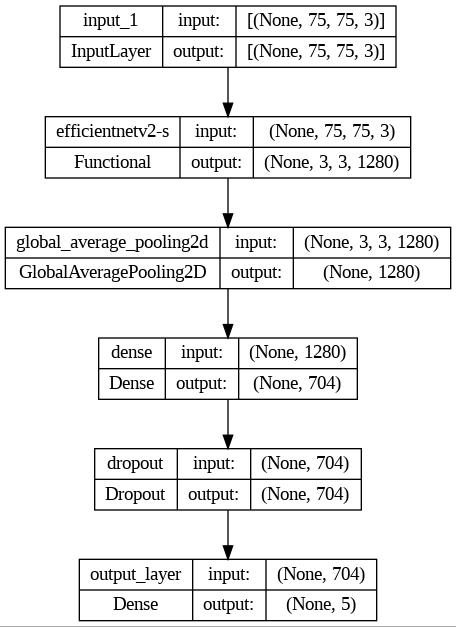

In [ ]:
eval_result = model.evaluate(X_test, y_test)
print("[test loss, test accuracy]:", eval_result)
tf.keras.utils.plot_model(model, to_file='model.jpg', show_shapes=True)

In [ ]:
pred = model.predict(X_test)
y_pred = np.array([np.argmax(x) for x in pred])
cr = classification_report(y_test, y_pred, digits=4, target_names=list(le.classes_)) 
print(cr)

108/108 [==============================] - 6s 59ms/step
                  precision    recall  f1-score   support

Blue Green Algae     0.9678    0.9655    0.9667      1216
          Diatom     0.9713    0.9155    0.9426       296
  Dinoflagellata     0.9344    0.9607    0.9474       178
      Euglenozoa     0.9511    0.9162    0.9333       191
     Green Algae     0.9574    0.9708    0.9641      1575

        accuracy                         0.9606      3456
       macro avg     0.9564    0.9457    0.9508      3456
    weighted avg     0.9607    0.9606    0.9606      3456



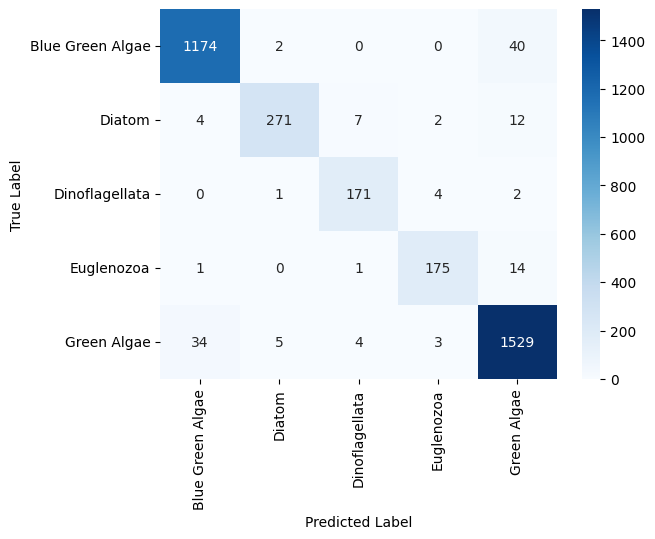

In [ ]:
cm = confusion_matrix(y_test, y_pred)
categories = list(le.classes_)

sns.heatmap(cm, annot=cm, fmt="", cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Save the Model

In [ ]:
model.save('/content/drive/MyDrive/Tugas Akhir/model')